In [2]:
import pandas as pd
import seaborn as sns

In [3]:
ls

results_eval.ipynb
Untitled.ipynb
wandb_export_2022-08-26T10_40_14.642-04_00.csv
wandb_export_2022-08-29T09_52_50.373-04_00.csv
wandb_export_2022-08-31T16_24_21.563-04_00.csv
wandb_export_2022-09-12T11_49_31.689-04_00.csv
wandb_export_2022-09-13T14_36_54.025-04_00.csv


In [101]:
df = pd.read_csv("wandb_export_2022-08-31T16_24_21.563-04_00.csv")

In [102]:
df2 = pd.read_csv("wandb_export_2022-09-13T14_36_54.025-04_00.csv")

In [103]:
df = pd.concat([df, df2]).reset_index(drop=True)
# -1 implies no chebyshev
df["datamodule/transform_args/cheb_order"] = df["datamodule/transform_args/cheb_order"].fillna("exact")

In [104]:
df["datamodule/transform_args/power"] = df["datamodule/transform_args/power"].fillna(2)

In [105]:
df["datamodule/transform_args/power"].value_counts()

1.0    1750
2.0     600
Name: datamodule/transform_args/power, dtype: int64

<AxesSubplot:xlabel='datamodule/dataset', ylabel='test/acc'>

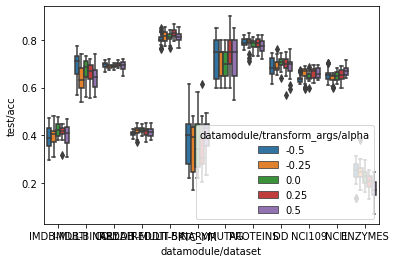

In [9]:
sns.boxplot(data=df, x="datamodule/dataset", y="test/acc", hue="datamodule/transform_args/alpha")


<AxesSubplot:xlabel='datamodule/transform_args/alpha', ylabel='test/acc'>

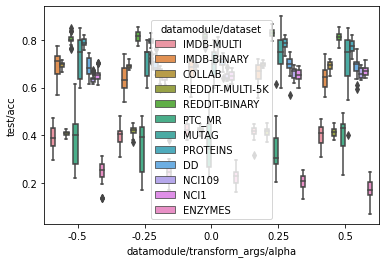

In [10]:
sns.boxplot(data=df, hue="datamodule/dataset", y="test/acc", x="datamodule/transform_args/alpha")

<AxesSubplot:xlabel='datamodule/transform_args/alpha', ylabel='test/acc'>

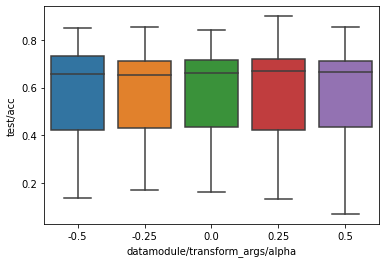

In [11]:
sns.boxplot(data=df, y="test/acc", x="datamodule/transform_args/alpha")

<AxesSubplot:xlabel='datamodule/transform_args/alpha', ylabel='test/acc'>

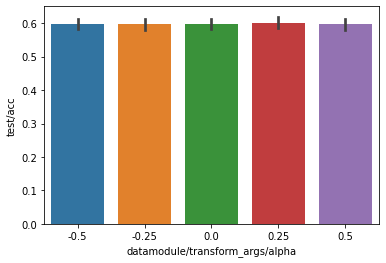

In [12]:
sns.barplot(data=df, y="test/acc", x="datamodule/transform_args/alpha")

<AxesSubplot:xlabel='datamodule/transform_args/alpha', ylabel='test/acc'>

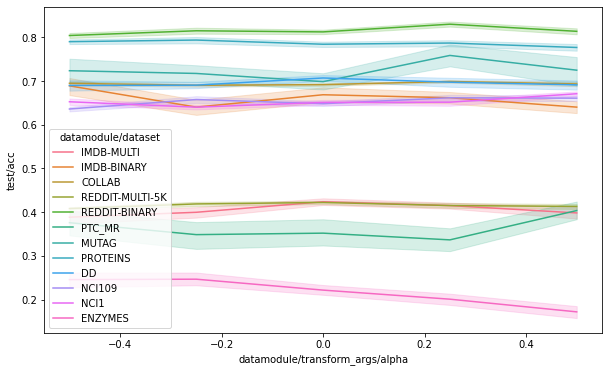

In [13]:
import matplotlib.pyplot as plt
plt.subplots(1,1,figsize=(10,6))
sns.lineplot(data=df, y="test/acc", x="datamodule/transform_args/alpha", hue="datamodule/dataset",)

In [14]:
df.groupby(["datamodule/transform_args/alpha", "datamodule/dataset", "datamodule/transform_args/power"]).mean()["test/acc"]

datamodule/transform_args/alpha  datamodule/dataset  datamodule/transform_args/power
-0.5                             COLLAB              1.0                                0.693581
                                                     2.0                                0.699023
                                 DD                  1.0                                0.700127
                                                     2.0                                0.660496
                                 ENZYMES             1.0                                0.254018
                                                                                          ...   
 0.5                             PTC_MR              2.0                                0.452604
                                 REDDIT-BINARY       1.0                                0.820238
                                                     2.0                                0.795089
                                 REDDIT-MU

In [121]:
def process_line(means, highlight, highlight_index, highlight_max):
    if highlight:
        if highlight_max:
            tops = set(means.groupby(highlight_index).idxmax())
        else:
            tops = set(means.groupby(highlight_index).idxmin())
    else:
        tops = set()
    def process_line(x):
        if x.name in tops:
            return rf"\textbf{{{x['mean']:0.3f} $\pm$ {x['std']:0.3f}}}"
        return rf"{x['mean']:0.3f} $\pm$ {x['std']:0.3f}"
    return process_line
def mean_pm_std(data, index, columns, value, highlight=True, highlight_cols=True, highlight_max=True):
    assert len(data) > 0
    groupby = data.groupby([*index, *columns])
    means = groupby.mean()[value].rename("mean")
    stds = groupby.std()[value].rename("std")
    ddf = pd.concat([means, stds], axis=1).T
    highlight_index = columns if highlight_cols else index
    ddf = ddf.apply(process_line(means, highlight, highlight_index, highlight_max))
    ddf = ddf.reset_index().pivot(index=index, columns=columns)
    ddf.columns = [col[1] for col in ddf.columns.values]
    return ddf
    #for i in range(len(means)):
        #means.iloc[i,:]
#mean_pm_std(df[df["datamodule/transform_args/power"] == 1].groupby(["datamodule/transform_args/alpha", "datamodule/dataset"]))

In [17]:
df["datamodule/transform_args/cheb_order"].value_counts()

exact    1150
100.0     600
10.0      600
Name: datamodule/transform_args/cheb_order, dtype: int64

In [106]:
clean_df = df.rename(columns={"datamodule/transform_args/alpha": r"$\alpha$", 
                              "datamodule/transform_args/power": "power", 
                              "datamodule/dataset": "dataset","test/acc": "acc",
                              "datamodule/transform_args/cheb_order": r"$\tau$",
                             })
clean_df["power"] = clean_df["power"].astype(int)
clean_df[r"$\alpha$"] = clean_df[r"$\alpha$"].round(2) #apply(lambda x: f"{x:0.2}")

In [107]:
results = mean_pm_std(clean_df[(clean_df[r"$\alpha$"] == 0)], 
                      index=[ "power", r"$\tau$",],
                      columns=["dataset"], value="acc").T
results

power                                     1                              \
$\tau$                                 10.0                       100.0   
COLLAB                    0.686 $\pm$ 0.010  \textbf{0.698 $\pm$ 0.005}   
DD                        0.699 $\pm$ 0.017           0.696 $\pm$ 0.028   
ENZYMES                   0.221 $\pm$ 0.032  \textbf{0.242 $\pm$ 0.028}   
IMDB-BINARY               0.683 $\pm$ 0.019           0.695 $\pm$ 0.012   
IMDB-MULTI       \textbf{0.444 $\pm$ 0.030}           0.402 $\pm$ 0.014   
MUTAG            \textbf{0.750 $\pm$ 0.035}           0.735 $\pm$ 0.034   
NCI1                      0.663 $\pm$ 0.022           0.637 $\pm$ 0.017   
NCI109           \textbf{0.675 $\pm$ 0.009}           0.631 $\pm$ 0.013   
PROTEINS                  0.780 $\pm$ 0.024  \textbf{0.797 $\pm$ 0.013}   
PTC_MR                    0.292 $\pm$ 0.090           0.289 $\pm$ 0.069   
REDDIT-BINARY             0.791 $\pm$ 0.013           0.814 $\pm$ 0.014   
REDDIT-MULTI-5K           0.419 $\pm$ 0.006  \textbf{0.430 $\pm$ 0.013}   

power                                                                 2  
$\tau$                                exact                       exact  
COLLAB                    0.690 $\pm$ 0.007           0.694 $\pm$ 0.007  
DD                        0.714 $\pm$ 0.015  \textbf{0.720 $\pm$ 0.017}  
ENZYMES                                 NaN           0.201 $\pm$ 0.023  
IMDB-BINARY      \textbf{0.713 $\pm$ 0.021}           0.584 $\pm$ 0.019  
IMDB-MULTI                0.421 $\pm$ 0.027           0.428 $\pm$ 0.016  
MUTAG                     0.675 $\pm$ 0.063           0.640 $\pm$ 0.021  
NCI1                      0.638 $\pm$ 0.006  \textbf{0.667 $\pm$ 0.004}  
NCI109                    0.641 $\pm$ 0.004           0.647 $\pm$ 0.008  
PROTEINS                  0.778 $\pm$ 0.024           0.783 $\pm$ 0.017  
PTC_MR                    0.384 $\pm$ 0.097  \textbf{0.443 $\pm$ 0.054}  
REDDIT-BINARY             0.820 $\pm$ 0.009  \textbf{0.825 $\pm$ 0.009}  
REDDIT-MULTI-5K           0.419 $\pm$ 0.011           0.421 $\pm$ 0.014

In [108]:
results = mean_pm_std(clean_df[(clean_df[r"$\alpha$"] == 0) & (clean_df["power"] == 1)], index=[r"$\tau$"], columns=["dataset"], value="acc").T
results

$\tau$,10.0,100.0,exact
COLLAB,0.686 $\pm$ 0.010,\textbf{0.698 $\pm$ 0.005},0.690 $\pm$ 0.007
DD,0.699 $\pm$ 0.017,0.696 $\pm$ 0.028,\textbf{0.714 $\pm$ 0.015}
ENZYMES,0.221 $\pm$ 0.032,\textbf{0.242 $\pm$ 0.028},NaN
IMDB-BINARY,0.683 $\pm$ 0.019,0.695 $\pm$ 0.012,\textbf{0.713 $\pm$ 0.021}
IMDB-MULTI,\textbf{0.444 $\pm$ 0.030},0.402 $\pm$ 0.014,0.421 $\pm$ 0.027
MUTAG,\textbf{0.750 $\pm$ 0.035},0.735 $\pm$ 0.034,0.675 $\pm$ 0.063
NCI1,\textbf{0.663 $\pm$ 0.022},0.637 $\pm$ 0.017,0.638 $\pm$ 0.006
NCI109,\textbf{0.675 $\pm$ 0.009},0.631 $\pm$ 0.013,0.641 $\pm$ 0.004
PROTEINS,0.780 $\pm$ 0.024,\textbf{0.797 $\pm$ 0.013},0.778 $\pm$ 0.024
PTC_MR,0.292 $\pm$ 0.090,0.289 $\pm$ 0.069,\textbf{0.384 $\pm$ 0.097}


In [122]:
# W1 vs W2 kernels across alpha
results = mean_pm_std(clean_df[(clean_df["dataset"] != "ENZYMES") & (clean_df[r"$\tau$"] == "exact")], 
                      index=["power", r"$\tau$"], 
                      columns=[r"$\alpha$"], 
                      value="acc").T
print(results.style.to_latex(hrules=True, ))
results

\begin{tabular}{lll}
\toprule
power & 1 & 2 \\
$\tau$ & exact & exact \\
\midrule
-0.500000 & \textbf{0.617 $\pm$ 0.144} & 0.616 $\pm$ 0.167 \\
-0.250000 & \textbf{0.640 $\pm$ 0.149} & 0.626 $\pm$ 0.150 \\
0.000000 & \textbf{0.626 $\pm$ 0.149} & 0.623 $\pm$ 0.136 \\
0.250000 & 0.619 $\pm$ 0.165 & \textbf{0.638 $\pm$ 0.163} \\
0.500000 & \textbf{0.626 $\pm$ 0.149} & 0.616 $\pm$ 0.140 \\
\bottomrule
\end{tabular}



power,1,2
$\tau$,exact,exact
-0.50,\textbf{0.617 $\pm$ 0.144},0.616 $\pm$ 0.167
-0.25,\textbf{0.640 $\pm$ 0.149},0.626 $\pm$ 0.150
0.00,\textbf{0.626 $\pm$ 0.149},0.623 $\pm$ 0.136
0.25,0.619 $\pm$ 0.165,\textbf{0.638 $\pm$ 0.163}
0.50,\textbf{0.626 $\pm$ 0.149},0.616 $\pm$ 0.140


In [123]:
results = mean_pm_std(clean_df[(clean_df["dataset"] != "ENZYMES") & (clean_df["power"] == 1)], 
                      index=[r"$\tau$"], 
                      columns=["dataset"], 
                      value="acc", highlight=False).T
print(results.style.to_latex(hrules=True))
results

\begin{tabular}{llll}
\toprule
$\tau$ & 10.000000 & 100.000000 & exact \\
\midrule
COLLAB & 0.692 $\pm$ 0.010 & 0.683 $\pm$ 0.012 & 0.702 $\pm$ 0.009 \\
DD & 0.685 $\pm$ 0.025 & 0.698 $\pm$ 0.024 & 0.695 $\pm$ 0.039 \\
IMDB-BINARY & 0.688 $\pm$ 0.040 & 0.666 $\pm$ 0.050 & 0.691 $\pm$ 0.031 \\
IMDB-MULTI & 0.406 $\pm$ 0.046 & 0.414 $\pm$ 0.029 & 0.398 $\pm$ 0.027 \\
MUTAG & 0.761 $\pm$ 0.074 & 0.733 $\pm$ 0.063 & 0.688 $\pm$ 0.070 \\
NCI1 & 0.653 $\pm$ 0.016 & 0.659 $\pm$ 0.029 & 0.645 $\pm$ 0.030 \\
NCI109 & 0.668 $\pm$ 0.022 & 0.628 $\pm$ 0.013 & 0.658 $\pm$ 0.023 \\
PROTEINS & 0.772 $\pm$ 0.023 & 0.799 $\pm$ 0.016 & 0.782 $\pm$ 0.022 \\
PTC_MR & 0.325 $\pm$ 0.095 & 0.333 $\pm$ 0.097 & 0.387 $\pm$ 0.089 \\
REDDIT-BINARY & 0.805 $\pm$ 0.021 & 0.822 $\pm$ 0.021 & 0.814 $\pm$ 0.021 \\
REDDIT-MULTI-5K & 0.410 $\pm$ 0.013 & 0.422 $\pm$ 0.013 & 0.417 $\pm$ 0.016 \\
\bottomrule
\end{tabular}



$\tau$,10.0,100.0,exact
COLLAB,0.692 $\pm$ 0.010,0.683 $\pm$ 0.012,0.702 $\pm$ 0.009
DD,0.685 $\pm$ 0.025,0.698 $\pm$ 0.024,0.695 $\pm$ 0.039
IMDB-BINARY,0.688 $\pm$ 0.040,0.666 $\pm$ 0.050,0.691 $\pm$ 0.031
IMDB-MULTI,0.406 $\pm$ 0.046,0.414 $\pm$ 0.029,0.398 $\pm$ 0.027
MUTAG,0.761 $\pm$ 0.074,0.733 $\pm$ 0.063,0.688 $\pm$ 0.070
NCI1,0.653 $\pm$ 0.016,0.659 $\pm$ 0.029,0.645 $\pm$ 0.030
NCI109,0.668 $\pm$ 0.022,0.628 $\pm$ 0.013,0.658 $\pm$ 0.023
PROTEINS,0.772 $\pm$ 0.023,0.799 $\pm$ 0.016,0.782 $\pm$ 0.022
PTC_MR,0.325 $\pm$ 0.095,0.333 $\pm$ 0.097,0.387 $\pm$ 0.089
REDDIT-BINARY,0.805 $\pm$ 0.021,0.822 $\pm$ 0.021,0.814 $\pm$ 0.021


In [ ]:
r2 = clean_df.groupby([r"$\alpha$", "power", "dataset"]).mean()["acc"].reset_index().pivot(index=[r"$\alpha$", "power", ], columns=["dataset"]).T
r2

$\alpha$                -0.50               -0.25                0.00  \
power                       1         2         1         2         1   
    dataset                                                             
acc COLLAB           0.693581  0.699023  0.689492  0.693164  0.691133   
    DD               0.700127  0.660496  0.696150  0.674287  0.702539   
    ENZYMES          0.254018  0.228795  0.261496  0.216741  0.231808   
    IMDB-BINARY      0.720636  0.587674  0.660937  0.578906  0.697135   
    IMDB-MULTI       0.406288  0.335000  0.399290  0.400909  0.422386   
    MUTAG            0.706667  0.775000  0.710000  0.740000  0.718966   
    NCI1             0.653306  0.650908  0.637536  0.648673  0.646002   
    NCI109           0.627222  0.662853  0.650401  0.679920  0.648755   
    PROTEINS         0.786458  0.801562  0.794792  0.791406  0.784896   
    PTC_MR           0.379167  0.366146  0.330903  0.401563  0.321701   
    REDDIT-BINARY    0.801042  0.814286  0.806696  0.840625  0.808333   
    REDDIT-MULTI-5K  0.405742  0.415811  0.413492  0.434942  0.422724   

$\alpha$                           0.25                0.50            
power                       2         1         2         1         2  
    dataset                                                            
acc COLLAB           0.694258  0.698698  0.700391  0.689570  0.705273  
    DD               0.720482  0.686073  0.731827  0.680390  0.724355  
    ENZYMES          0.201116  0.199554  0.203348  0.168304  0.178795  
    IMDB-BINARY      0.583594  0.679688  0.608594  0.651302  0.607812  
    IMDB-MULTI       0.428239  0.410795  0.427443  0.391402  0.418864  
    MUTAG            0.640000  0.730000  0.845000  0.770000  0.590000  
    NCI1             0.666836  0.649576  0.658084  0.675122  0.658868  
    NCI109           0.646811  0.664511  0.653974  0.667078  0.642484  
    PROTEINS         0.782813  0.784115  0.796094  0.771354  0.793750  
    PTC_MR           0.442708  0.322396  0.379167  0.386853  0.452604  
    REDDIT-BINARY    0.825446  0.832887  0.822321  0.820238  0.795089  
    REDDIT-MULTI-5K  0.420666  0.421044  0.397526  0.420464  0.391276

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'IMDB-MULTI'),
  Text(1, 0, 'IMDB-BINARY'),
  Text(2, 0, 'COLLAB'),
  Text(3, 0, 'REDDIT-MULTI-5K'),
  Text(4, 0, 'REDDIT-BINARY'),
  Text(5, 0, 'PTC_MR'),
  Text(6, 0, 'MUTAG'),
  Text(7, 0, 'PROTEINS'),
  Text(8, 0, 'DD'),
  Text(9, 0, 'NCI109'),
  Text(10, 0, 'NCI1'),
  Text(11, 0, 'ENZYMES')])

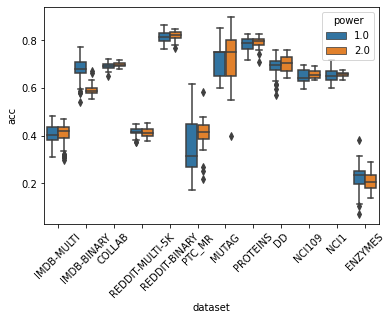

In [23]:
sns.boxplot(data=clean_df, x="dataset", y="acc", hue="power")
plt.xticks(rotation=45)

(array([0]), [Text(0, 0, 'IMDB-BINARY')])

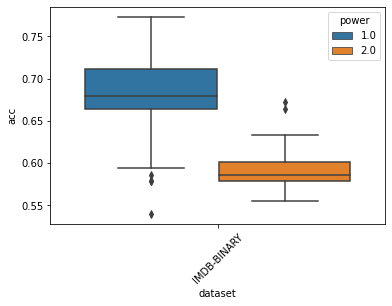

In [24]:
sns.boxplot(data=clean_df[clean_df["dataset"] == "IMDB-BINARY"], x="dataset", y="acc", hue="power")
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'IMDB-MULTI'),
  Text(1, 0, 'IMDB-BINARY'),
  Text(2, 0, 'COLLAB'),
  Text(3, 0, 'REDDIT-MULTI-5K'),
  Text(4, 0, 'REDDIT-BINARY'),
  Text(5, 0, 'PTC_MR'),
  Text(6, 0, 'MUTAG'),
  Text(7, 0, 'PROTEINS'),
  Text(8, 0, 'DD'),
  Text(9, 0, 'NCI109'),
  Text(10, 0, 'NCI1'),
  Text(11, 0, 'ENZYMES')])

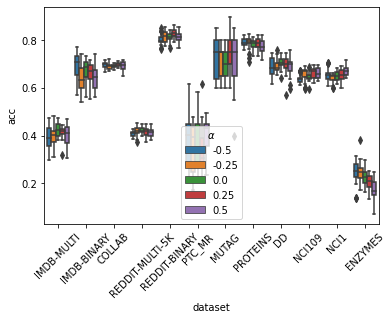

In [25]:
sns.boxplot(data=clean_df, x="dataset", y="acc", hue=r"$\alpha$")
plt.xticks(rotation=45)

<AxesSubplot:xlabel='$\\alpha$-power', ylabel='None-dataset'>

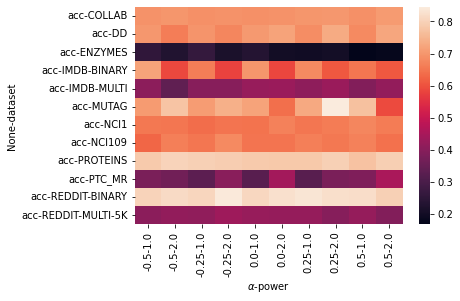

In [26]:
sns.heatmap(r2)

In [27]:
results.

SyntaxError: invalid syntax (3562696729.py, line 1)

In [ ]:
print(mean_pm_std(df, index=["datamodule/transform_args/alpha", "datamodule/transform_args/power"], columns=[ "datamodule/dataset"], value="test/acc").T.style.to_latex())

In [ ]:
df.groupby(["datamodule/transform_args/alpha", "datamodule/dataset"]).mean()["test/acc"].reset_index().pivot(index="datamodule/dataset", columns="datamodule/transform_args/alpha")


In [ ]:
df.groupby(["datamodule/transform_args/alpha"]).mean()["test/acc"].sort_values()

In [ ]:
df.groupby(["datamodule/transform_args/alpha", "datamodule/dataset"]).mean()["test/acc"].groupby("datamodule/dataset").idxmax().apply(lambda x: x[0]).value_counts()